In [1]:
import pandas as pd

In [2]:
import sklearn; #sklearn.show_versions()

In [3]:
from sklearn.linear_model import LogisticRegression

In [4]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [5]:
import matplotlib.pyplot as plt

In [6]:
train = pd.read_csv('sample_data/train.csv', index_col=0)
train_data  = train.copy()

In [7]:
test = pd.read_csv('sample_data/test.csv', index_col=0)
test_data = test.copy()

In [8]:
# Доля тествой во всей выборке
#sum(all_data['lost_id'].notnull()) / all_data['lost_id'].shape[0]

# Разведочный анализ данных (англ. exploratory data analysis, EDA)

In [9]:
train_data['ts'] = pd.to_datetime(train_data['ts'])
test_data['ts'] = pd.to_datetime(test_data['ts'])
test['ts'] = pd.to_datetime(test['ts'])
all_data = pd.concat([train_data, test_data], axis=0)

In [10]:
train_data.info()
#Нулевый значений нет

<class 'pandas.core.frame.DataFrame'>
Index: 35172 entries, 0 to 37516
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   user_id  35172 non-null  int64         
 1   ts       35172 non-null  datetime64[ns]
 2   gate_id  35172 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


In [11]:
train_data.describe()
#Каких-то аномалей нет

,user_id,ts,gate_id
count,35172.000000,35172,35172.000000
mean,28.329239,2022-10-04 23:26:53.715881728,6.723473
min,0.000000,2022-07-29 09:08:54,-1.000000
25%,12.000000,2022-08-25 11:49:47,4.000000
50%,29.000000,2022-09-28 13:50:42.500000,5.000000
75%,47.000000,2022-11-05 18:06:49.750000128,10.000000
max,57.000000,2022-12-31 20:39:31,16.000000
std,17.883851,NaN,3.216261


In [12]:
test_data.info()
#Нулевый значений нет

<class 'pandas.core.frame.DataFrame'>
Index: 6620 entries, 37518 to 44641
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ts       6620 non-null   datetime64[ns]
 1   gate_id  6620 non-null   int64         
 2   lost_id  6620 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 206.9 KB


In [13]:
test_data.describe()
#Каких-то аномалей нет

,ts,gate_id,lost_id
count,6620,6620.000000,6620.000000
mean,2023-01-21 07:41:46.275075584,6.997130,28.348792
min,2023-01-03 08:21:00,-1.000000,0.000000
25%,2023-01-11 19:11:02,4.000000,12.000000
50%,2023-01-20 10:08:23.500000,6.000000,29.000000
75%,2023-01-27 19:41:06.500000,10.000000,47.000000
max,2023-02-24 19:44:09,15.000000,57.000000
std,NaN,3.340182,17.969900


In [14]:
duplicates = train_data.duplicated()
print(duplicates)
# Дубликатов нет

0        False
1        False
3        False
4        False
5        False
         ...  
37512    False
37513    False
37514    False
37515    False
37516    False
Length: 35172, dtype: bool


In [15]:
duplicates = test_data.duplicated()
print(duplicates)
# Дубликатов нет

37518    False
37520    False
37521    False
37522    False
37523    False
         ...  
44637    False
44638    False
44639    False
44640    False
44641    False
Length: 6620, dtype: bool


<Axes: >

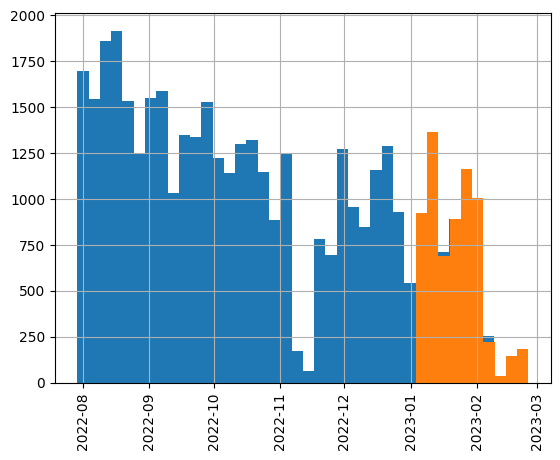

In [16]:
plt.figure()
plt.xticks(rotation='vertical')
all_data['ts'].hist(bins=40)
test['ts'].hist(bins=10)

In [17]:
all_data['lost_id'].value_counts().count()

34

# Гипотеза
Предположим что мы можем найти перепутанные ID пользователяей создав модель на основе признаков учитывающий поведение сотрудника в течение времени года. Такими будут: начало и конец рабочего дня, средняя продолжительность рабочего дня, последний и первый день месяца, самые посещаемые дни сотрудниками в месяц(предпологае что это дни зарплаты и аванса), выходные и праздничные дни, самые частые и в среднем часы продолжительности рабочего дня, час, число месяца, месяц, квартал, год, количество отработаных часов за выбранный период. Также учтем самый часто проходимый турникет, и последовательности турникетов, которые проходит сотрудник каждый день. Добавим эти признаки в модель.       

# Создание новых признаков данных
Создадим новые признаки на основе гипотезы

Добавими в таблицы тренировочных и тестовых данных следующие признаки


*    hour - час прохода ч/з турникет, так как разные люди могут приходить и уходить в разное время
*    day - число месяца прохода ч/з турникет, так как люди могут работать в разные дни
*   month - месяц прохода ч/з турникет, так как люди могут работать в разные месяцы
*   dayofweek - день недели прохода ч/з турникет, так как люди могут работать в разные дни недели
*   quarter - квартал прохода ч/з турникет, так как люди могут работать в разные дни недели
*   year - год прохода ч/з турникет, так как люди могут работать в разные дни недели




In [18]:
train_data['hour'] = train_data['ts'].dt.hour.values
test_data['hour'] = test_data['ts'].dt.hour.values

In [19]:
train_data['day'] = train_data['ts'].dt.day.values
test_data['day'] = test_data['ts'].dt.day.values

In [20]:
train_data['month'] = train_data['ts'].dt.month.values
test_data['month'] = test_data['ts'].dt.month.values

In [21]:
train_data['dayofweek'] = train_data['ts'].dt.dayofweek.values
test_data['dayofweek'] = test_data['ts'].dt.dayofweek.values

In [22]:
train_data['quarter']  = train_data['ts'].dt.quarter.values
test_data['quarter']  = test_data['ts'].dt.quarter.values

In [23]:
train_data['year'] = train_data['ts'].dt.year.values
test_data['year'] = test_data['ts'].dt.year.values

In [24]:
#Количество проведенных дней на работе каждым сотрудником
train_data["year_month_day"] = train_data["ts"].dt.to_period("D")
train_data['count_work_days']  = train_data.groupby('user_id')['year_month_day'].transform('count')
test_data["year_month_day"] = test_data["ts"].dt.to_period("D")
test_data['count_work_days']  = test_data.groupby('lost_id')['year_month_day'].transform('count')

In [25]:
#train_data

In [26]:
#test_data

Добавим признак выходного дня is_dayoff в тренировочную и тестовую таблицы, так как сотрудник может как работать в выходной так и нет

In [27]:
def is_dayoff(row):
    '''
    Возвращает 1 если текущий день - выходной или праздничный, 0 - если будний.
    Применяется построчно к DataFrame.
    Например, df['dayoff'] = df.apply(is_dayoff, axis=1)

    Parameters
    ----------
    row - строка pandas DataFrame

    Return
    ------
    row - новая запись в pandas DataFrame
    '''
    #Новогодние выходные
    if row['month'] == 1 and row['day'] == 1:
        return 1
    elif row['month'] == 1 and row['day'] == 2:
        return 1
    elif row['month'] == 1 and row['day'] == 3:
        return 1
    elif row['month'] == 1 and row['day'] == 4:
        return 1
    elif row['month'] == 1 and row['day'] == 5:
        return 1
    elif row['month'] == 1 and row['day'] == 6:
        return 1
    # Рождество
    elif row['month'] == 1 and row['day'] == 7:
        return 1
    # День защитника отечества
    elif row['month'] == 2 and row['day'] == 23:
        return 1
     # Международный женский день
    elif row['month'] == 3 and row['day'] == 8:
        return 1
    # Майские праздники
    elif row['month'] == 5 and row['day'] == 1:
        return 1
    elif row['month'] == 5 and row['day'] == 9:
        return 1
    # День независимости
    elif row['month'] == 6 and row['day'] == 12:
        return 1
    #  День народного единства
    elif row['month'] == 11 and row['day'] == 4:
        return 1
    # Обычные выходные
    elif row['dayofweek'] >= 5:
        return 1
    else:
        return 0

In [28]:
# Добавление нового столбца признака выходного дня. Значение 1 - первый день, 0 - нет
train_data['is_dayoff'] = train_data.apply(is_dayoff, axis=1)
test_data['is_dayoff'] = test_data.apply(is_dayoff, axis=1)

Добавим признаки последнего дня месяца - last_day_month и первого - first_day_month в тренировочную и тестовую таблицы, так как сотрудник может как работать в этот день так и нет.

In [29]:
# Последний день месяца.
def last_day_month(row):
# Январь - 31 день  Февраль - 28 дней (29 в високосном) Март - 31 день Апрель - 30 дней
# Май - 31 день Июнь - 30 дней Июль - 31 день Август - 31 день Сентябрь - 30 дней
# Октябрь - 31 день Ноябрь - 30 дней Декабрь - 31 день
  if (((row['month'] == 1 ) or (row['month'] == 3) or  (row['month'] == 5) or  (row['month'] == 7) or (row['month'] == 8) or (row['month'] ==10) or (row['month'] == 12)) and (row['day'] == 31)):
        return 1
  elif (row['month'] == 2) and (row['day'] == 28 or row['day'] == 29):
        return 1
  elif (row['month'] == 4 or row['month'] == 6  or row['month'] == 9 or row['month'] == 11) and (row['day'] == 30):
        return 1
  else:
        return 0

In [30]:
#Добавление нового столбца признака последнего дня месяца. Значение 1 - последний день, 0 - нет
train_data['last_day_month'] = train_data.apply(last_day_month, axis=1)
test_data['last_day_month'] = test_data.apply(last_day_month, axis=1)

In [31]:
# Первый день месяца
def first_day_month(row):
  if row['day'] == 1:
        return 1
  else:
        return 0

In [32]:
#Добавление нового столбца признака первого дня месяца
train_data['first_day_month'] = train_data.apply(first_day_month, axis=1)
test_data['first_day_month'] = test_data.apply(first_day_month, axis=1)

In [33]:
#all_data['gate_id_counts'] = all_data['gate_id'].value_counts()
#cut_labels_4 = [ 1, 2, 3, 4, 5, 6, 7, 8, 9]
#cut_bins = [0, 10, 100, 1000, 2000, 3000, 4000, 5000, 6000, 10000]
#all_data['cat_gate_counts'] = pd.cut(all_data['gate_id_counts'],
#                       bins=cut_bins,
#                       labels=cut_labels_4)
#all_data['user_id'].value_counts()

Добавим  в тренировочную и тестовую таблицы данные о поведении сотрудника в течение дня на работе, которые индивидуальны для каждоко человека
*   ts_min - начало  рабочего дня
*   ts_max - конец рабочего дня
*   ts_max_min рабочий день
*   ts_count - количество отработотанных дней за выбранный период
*   gate_id_list - список номеров турникетов проходимых сотрудником за день

In [34]:
#all_data

In [35]:
def max_min(x):
    return x.max() - x.min()
def list_gate(x):
    return  list(x)
def mode_1(x):
    return x.mode().iloc[0]

In [36]:
# Создадим насколько таблиц с группировками(и объединим их) для нахождения минимального часа и
# максимального за день по сотруднику, длинну работчего дня а так же самое частое и среднее значение
# этих временных меток и самый частоиспользуемый турникет
# для тренировочной таблицы
all_data_gr = train_data.groupby(['user_id','year_month_day'], as_index=False).agg({'ts':['min','max', max_min, 'count', mode_1],'gate_id':[list_gate, mode_1]})
all_data_gr[('gate_id', 'list_gate')] = all_data_gr[('gate_id', 'list_gate')].apply(lambda x:"".join(map(str,x)))
all_data_gr[('ts', 'min')] = all_data_gr[('ts', 'min')].dt.hour.values
all_data_gr[('ts', 'max')] = all_data_gr[('ts', 'max')].dt.hour.values
all_data_gr[('ts', 'mode_1')] = all_data_gr[('ts', 'mode_1')].dt.hour.values
all_data_gr[('ts', 'max_min')] = all_data_gr[('ts', 'max_min')].dt.components.hours
all_data_gr_mean = all_data_gr.groupby(['user_id'],as_index=False).agg({('ts', 'min'):['mean', mode_1],('ts', 'max'):['mean', mode_1],('ts', 'max_min'):['mean',mode_1]})
all_data_gr_mean.columns = ['user_id','ts_min_mean', 'ts_min_mode','ts_max_mean', 'ts_max_mode', 'ts_max_min_mean','ts_max_min_mode']
all_data_gr.columns = ['user_id','year_month_day', 'ts_min', 'ts_max', 'ts_max_min', 'ts_count', 'ts_mode', 'gate_id_list','gate_mode']
all_data_gr = all_data_gr.merge(all_data_gr_mean, how='inner', left_on='user_id', right_on='user_id')


In [37]:
all_data_gr.head(1)

,user_id,year_month_day,ts_min,ts_max,ts_max_min,ts_count,ts_mode,gate_id_list,gate_mode,ts_min_mean,ts_min_mode,ts_max_mean,ts_max_mode,ts_max_min_mean,ts_max_min_mode
0,0,2022-07-29,10,18,8,12,10,331166733101144,3,10.113402,10,18.072165,18,7.412371,8


In [38]:
# Создадим насколько таблиц с группировками(и объединим их) для нахождения минимального часа и
# максимального за день по сотруднику, длинну работчего дня а так же самое частое и среднее значение
# этих временных меток и самый частоиспользуемый турникет
# для тестовой таблицы
all_data_gr_t = test_data.groupby(['lost_id','year_month_day'], as_index=False).agg({'ts':['min','max', max_min, 'count', mode_1],'gate_id':[list_gate, mode_1]})
all_data_gr_t[('gate_id', 'list_gate')] = all_data_gr_t[('gate_id', 'list_gate')].apply(lambda x:"".join(map(str,x)))
all_data_gr_t[('ts', 'min')] = all_data_gr_t[('ts', 'min')].dt.hour.values
all_data_gr_t[('ts', 'max')] = all_data_gr_t[('ts', 'max')].dt.hour.values
all_data_gr_t[('ts', 'mode_1')] = all_data_gr_t[('ts', 'mode_1')].dt.hour.values
all_data_gr_t[('ts', 'max_min')] = all_data_gr_t[('ts', 'max_min')].dt.components.hours
all_data_gr_mean_t = all_data_gr_t.groupby(['lost_id'],as_index=False).agg({('ts', 'min'):['mean', mode_1],('ts', 'max'):['mean', mode_1],('ts', 'max_min'):['mean',mode_1]})
all_data_gr_mean_t.columns = ['lost_id','ts_min_mean', 'ts_min_mode','ts_max_mean', 'ts_max_mode', 'ts_max_min_mean','ts_max_min_mode']
all_data_gr_t.columns = ['lost_id','year_month_day', 'ts_min', 'ts_max', 'ts_max_min', 'ts_count', 'ts_mode', 'gate_id_list','gate_mode']
all_data_gr_t = all_data_gr_t.merge(all_data_gr_mean_t, how='inner', left_on='lost_id', right_on='lost_id')


In [39]:
#all_data_gr

In [40]:
#all_data_gr_t

In [41]:
#Закодируем списки путей прохода через турникеты
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(all_data_gr_t['gate_id_list'])
all_data_gr_t['gate_id_list'] = encoder.transform(all_data_gr_t['gate_id_list'])
encoder.fit(all_data_gr['gate_id_list'])
all_data_gr['gate_id_list'] = encoder.transform(all_data_gr['gate_id_list'])

In [42]:
#all_data_gr_t

In [43]:
#Присоеденим полученные выше данные к тренировочной таблице
train_data = train_data.merge(all_data_gr, how='left', left_on=['user_id','year_month_day'], right_on=['user_id','year_month_day'])

In [44]:
#Присоеденим полученные выше данные к тестовой таблице
test_data = test_data.merge(all_data_gr_t, how='left', left_on=['lost_id','year_month_day'], right_on=['lost_id','year_month_day'])

In [45]:
#train_data

In [46]:
#Объединим тренировочную и тестовую выборки
all_data = pd.concat([train_data, test_data], axis=0)

 Проанализировав столбец day, увидим что есть число 5 - когда посещений максимальное количество.  Предполжим что это день зарплаты и добавим эту переменную в таблицу с названием salary_day. Значение 1 - это чило месяца 5, иначе 0. А сдледующие три числа 19, 26, 29 с большими и близкими числами дни аванса. Добавим новую переменную по этим числам с названием advance_day. Значение 1 - это числа месяца 19, 26, 29, иначе 0.

In [47]:
# Проанализировав столбец day, увидим что есть число 5 - когда посещений максимальное количество.
# Предполжим что это день зарплаты и добавим эту переменную в таблицу с названием salary_day

all_data['day'].value_counts()

,count
day,
5,1906
19,1677
29,1669
26,1665
1,1588
30,1568
2,1532
3,1532
9,1466


In [48]:
# День зарплаты
def salary_day(row):
  if row['day'] == 5:
        return 1
  else:
        return 0

In [49]:
# День аванса
def advance_day(row):
  if (row['day'] == 19) or (row['day'] == 29) or  (row['day'] == 26):
        return 1
  else:
        return 0

In [50]:
# Добавление новых признаков зарплаты salary_day и аванса advance_day в общую таблицу all_data
all_data['salary_day'] = all_data.apply(salary_day, axis=1)
all_data['advance_day'] = all_data.apply(advance_day, axis=1)

In [51]:
#all_data = all_data.assign(b_dya_8 = [1 if i < 9.0 else 0 for i in all_data['ts_min_mean']])
#all_data = all_data.assign(b_dya_9 = [1 if i < 10.0 else 0 for i in all_data['ts_min_mean']])
#all_data = all_data.assign(b_dya_10 = [1 if i < 11.0 else 0 for i in all_data['ts_min_mean']])
#all_data = all_data.assign(b_dya_10 = [1 if i < 12.0 else 0 for i in all_data['ts_min_mean']])

In [52]:
#all_data.hist(figsize=(9,9), bins=20, grid=False)
#plt.tight_layout()

In [53]:
#all_data.loc[(all_data['user_id'] == 0)][['dayofweek']].head(12)

In [54]:
#Список всех колонок
list(all_data.columns)

['user_id',
 'ts',
 'gate_id',
 'hour',
 'day',
 'month',
 'dayofweek',
 'quarter',
 'year',
 'year_month_day',
 'count_work_days',
 'is_dayoff',
 'last_day_month',
 'first_day_month',
 'ts_min',
 'ts_max',
 'ts_max_min',
 'ts_count',
 'ts_mode',
 'gate_id_list',
 'gate_mode',
 'ts_min_mean',
 'ts_min_mode',
 'ts_max_mean',
 'ts_max_mode',
 'ts_max_min_mean',
 'ts_max_min_mode',
 'lost_id',
 'salary_day',
 'advance_day']

In [55]:
#Занесем в cols_cat нужные признаки
cols_cat = [
 #'user_id',
 #'ts',
 #'gate_id',
 'hour',
 #'min',
 'day',
 'month',
 'dayofweek',
 'quarter',
 'year',
 #'year_month_day',
 #'count_work_days',
 'is_dayoff',
 'last_day_month',
 'first_day_month',
 'ts_min',
 'ts_max',
 'ts_max_min',
 'ts_count',
 #'ts_mode',
 'gate_id_list',
 'gate_mode',
 'ts_min_mean',
 #'ts_min_mode',
 'ts_max_mean',
 #'ts_max_mode',
 'ts_max_min_mean',
 'ts_max_min_mode',
 #'lost_id'
 'salary_day',
 'advance_day'
  ]

# Анализ данных с новыми признаками

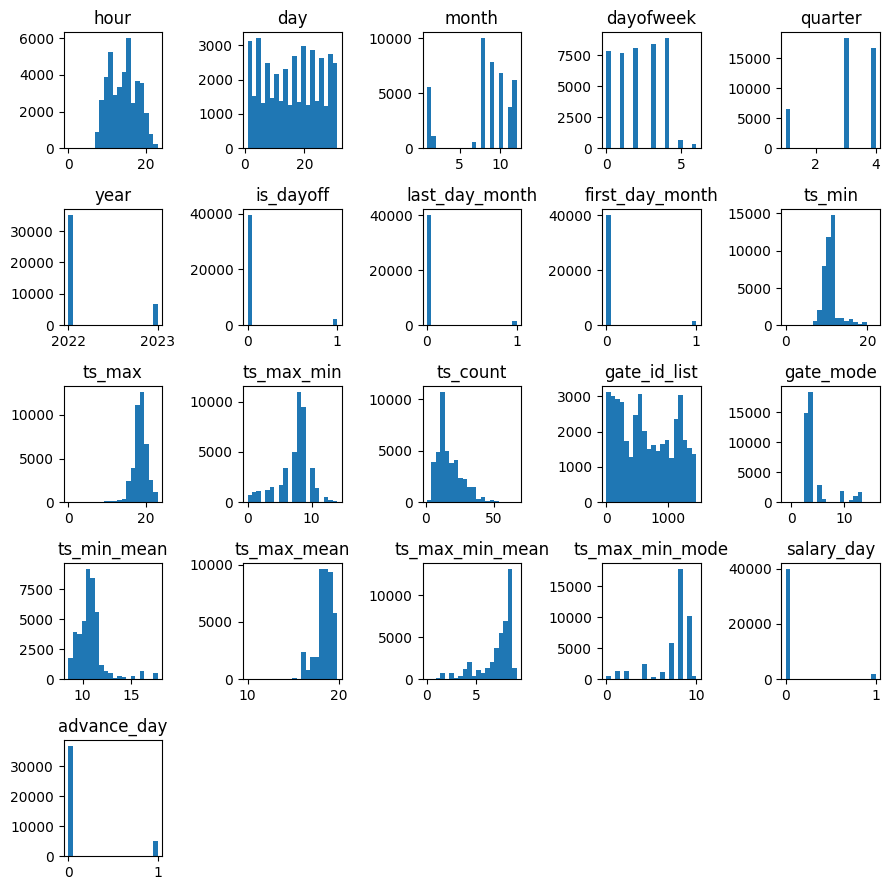

In [56]:
all_data[cols_cat].hist(figsize=(9,9), bins=20, grid=False)
plt.tight_layout()

#Матрица корреляций
Показывает линейную связь между переменными
Изменяется от -1 до 1
Корреляция - мера только линейной связи

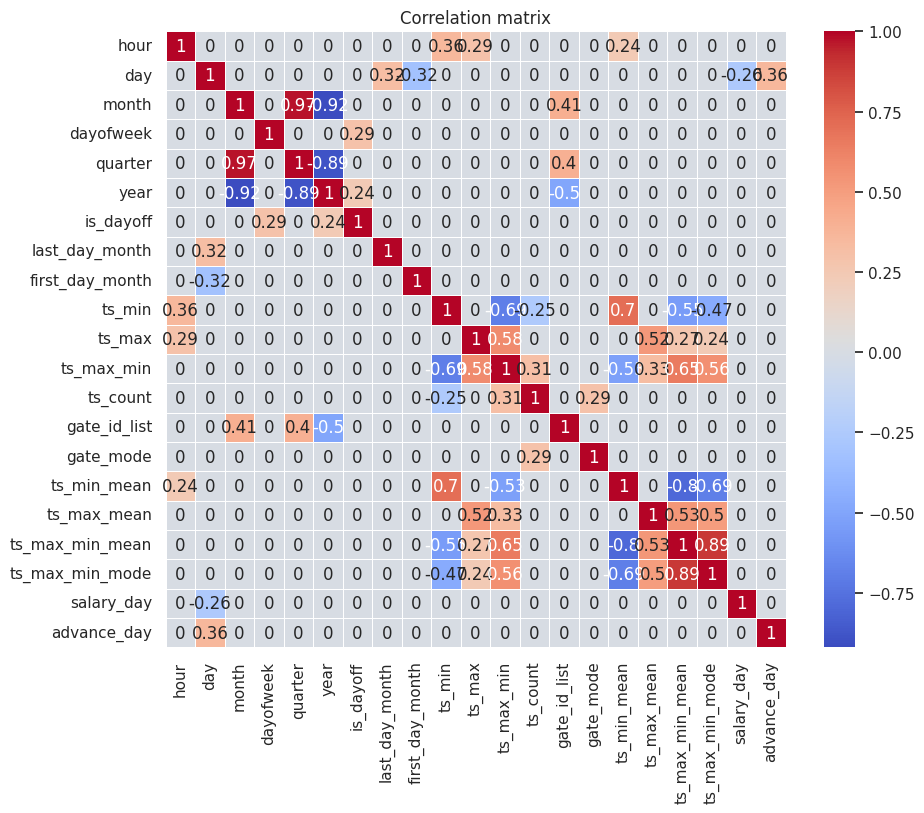

In [57]:
import seaborn as sns
import numpy as np
plt.figure(figsize = (10,8))

sns.set(font_scale=1)

corr_matrix = all_data[cols_cat].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()
# Увидим что квартал и год сильно коллерируют с месяцем, также среднее и мода продолжительности рабочего дня.
# Уберем их

In [58]:
cols_cat1 = [
 #'user_id',
 #'ts',
 #'gate_id',
 'hour',
 #'min',
 'day',
 'month',
 'dayofweek',
 #'quarter',
 # 'year',
 #'year_month_day',
 #'count_work_days',
 'is_dayoff',
 'last_day_month',
 'first_day_month',
 'ts_min',
 'ts_max',
 'ts_max_min',
 'ts_count',
 #'ts_mode',
 'gate_id_list',
 'gate_mode',
 'ts_min_mean',
 #'ts_min_mode',
 'ts_max_mean',
 #'ts_max_mode',
 #'ts_max_min_mean',
 #'ts_max_min_mode',
 #'lost_id'
 'salary_day',
 'advance_day'
  ]

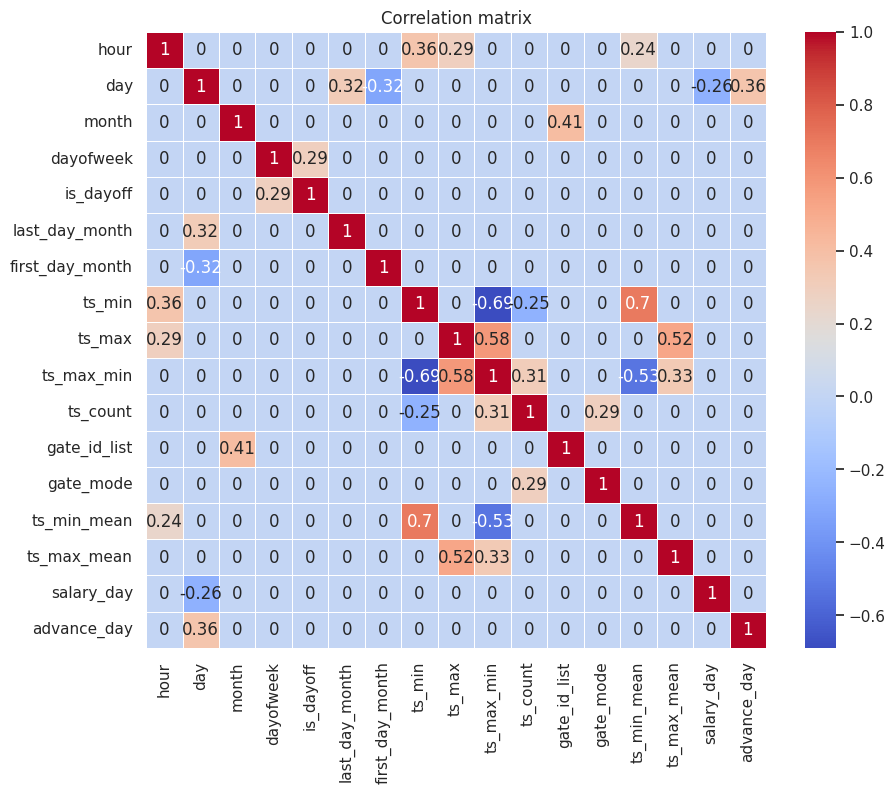

In [59]:
plt.figure(figsize = (10,8))

sns.set(font_scale=1)

corr_matrix = all_data[cols_cat1].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

# Выбор модели обучения
В качестве додели обучения будем использовать логистическую регрессию, поскольку это относительно простой алгоритм, который требует небольшого количества вычислительных ресурсов и может быть эффективно использован для решения большого количества задач классификации. Логистическая регрессия позволяет понимать, какие переменные влияют на классификацию и каким образом.Работает хорошо на небольших наборах данных: логистическая регрессия показывает хорошие результаты на небольших наборах данных. Небольшая вероятность переобучения. Логистическая регрессия склонна к менее переобучению, поскольку она не имеет множества параметров, которые нужно оптимизировать.

Подготовка тренировочной, валидационной, тестовой выборки для модели

Val index

In [60]:
# Для определения тренировочной и валидационной выборки
for_val = all_data[all_data['lost_id'].isnull()]
val_index = for_val['ts'] > '2022-11-30'

In [61]:
# Доля валидационной выборки
sum(val_index) / val_index.shape[0]

0.18614238598885477

In [62]:
# Определение тренировочной и валидационной выборки
train_idx = all_data['lost_id'].isnull()
train = all_data.loc[train_idx]
test = all_data.loc[~train_idx]

In [63]:
#test

In [64]:
#Отбрем данные для тренировки и валидации
X = train[~val_index].copy()
X_val = train[val_index].copy()

y = X['user_id'].astype(int)
y_val = X_val['user_id'].astype(int)


In [65]:
# Заполним нулями Nan-зниченияв столбцах
X.fillna(0.0, inplace=True)
X_val.fillna(0.0, inplace=True)

In [66]:
# Выберем только те колонки из таблицы со всеми
# созданными признаками (перем. cols_cat), которые необходимы для тренировки модели
X = X[cols_cat1]#.astype(int)
X_val = X_val[cols_cat1]#.astype(int)

In [67]:
# Сделаем нормирование отдельными скейлерами по X и по X_val, т.к. будущие данные скорее всего изменятся
scaler_X = StandardScaler()
scaler_X_val = StandardScaler()

scaler_X.fit(X)
scaler_X_val.fit(X_val)

X_scaled = scaler_X.transform(X)
X_val_scaled = scaler_X_val.transform(X_val)

# Обучение модели

In [68]:
#Будем использовать логистическую функцию
clf = LogisticRegression(random_state=1, solver='saga').fit(X_scaled, y)
y_pred = clf.predict(X_scaled)
y_val_pred = clf.predict(X_val_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [69]:
results = pd.DataFrame(y_val)
results['pred'] = y_val_pred
#results

In [70]:
results['user_id'].unique().shape

(43,)

In [71]:
# Предскажем самым частотным user_id на val
def mode_1(x):
    return x.mode().iloc[0]
res = results.groupby('user_id')['pred'].agg([mode_1, 'count'])
#display(res)
res = res.reset_index();
del res['count']

In [72]:
print('correct', (res['user_id'] == res['mode_1']).sum())
print('out of', res.shape[0])
print('or', int((res['user_id'] == res['mode_1']).sum()*100 / res.shape[0]), '%')

correct 18
out of 43
or 41 %


In [73]:
# Train предсказуемо имеет более высокую метрику
results2 = pd.DataFrame(y)
results2['pred'] = y_pred
res2 = results2.groupby('user_id')['pred'].agg([mode_1]).reset_index()

In [74]:
print('correct', (res2['user_id'] == res2['mode_1']).sum())
print('out of', res2.shape[0])
print('or', int((res2['user_id'] == res2['mode_1']).sum()*100 / res2.shape[0]), '%')

correct 44
out of 50
or 88 %


In [75]:
#test['lost_id']

In [76]:
X = train.copy()
y = X['user_id'].astype(int)
X_test = test.copy()

In [77]:
X.fillna(0.0, inplace=True)
X_test.fillna(0.0, inplace=True)

In [78]:
X = X[cols_cat].astype(int)
X_test = X_test[cols_cat].astype(int)

In [79]:
# Сделаем нормирование отдельными скейлерами по X и по X_test, т.к. будущие данные скорее всего изменятся

scaler_X = StandardScaler()
scaler_X_test = StandardScaler()

scaler_X.fit(X)
scaler_X_test.fit(X_test)

X_scaled = scaler_X.transform(X)
X_test_scaled = scaler_X_test.transform(X_test)

# Обучение модели

In [80]:
#Будем использовать логистическую функцию
clf = LogisticRegression(random_state=1,solver='saga').fit(X_scaled, y)
y_pred = clf.predict(X_scaled)
y_test_pred = clf.predict(X_test_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [81]:
answer = pd.DataFrame()
answer['lost_id'] = test['lost_id']
answer['preds'] = y_test_pred

In [82]:
# Предскажем самым частотным user_id
submit = pd.DataFrame(answer.groupby('lost_id')['preds'].agg([mode_1]))

In [83]:
submit.index = submit.index.astype(int)
submit.rename(columns={'mode_1':'preds'}, inplace=True)
submit

,preds
lost_id,
0,33
1,1
3,57
6,55
9,54
11,3
12,12
14,53
15,49


In [84]:
submit.shape[0]

34

In [85]:
submit.to_csv('answer.csv')
! zip answer_base.zip answer.csv

# Получится на борде 58, при равенстве весов (что не так), получилось бы 58 / (560/34) = 3.5,
# примерно 10% правильных user_id (но наверное больше, т.к. отгадали самые дешёвые). 560 = max в задаче.

updating: answer.csv (deflated 38%)


Подбор гиперпараметров для логистической регрессии

In [ ]:
# Grid search cross validation
#from sklearn.model_selection import GridSearchCV
#from sklearn.linear_model import LogisticRegression
#grid={"C":np.linspace(1, 100, 5), "penalty":["l1","l2"]}# l1 lasso l2 ridge
#logreg=LogisticRegression()
#logreg_cv=GridSearchCV(logreg,grid,cv=10)
#logreg_cv.fit(X_scaled,y)

#print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
#print("accuracy :",logreg_cv.best_score_)

Вывод о гипотезе.
 Не подошли признаки год и квартал.
В результате тренировки, валидации и модели логистической регрессии на выбранных признаках получилось найти 21 ID сотрудников на вадидационной выборке, 44 на тренировочных данных. Тестовая дала результат 4. Мы может сделать вывод о том что подобранные признаки помогают найти часть утеянных ID. Необходимо еще ислледовать данные чтобы подобрать новые признаки.   